In [1]:
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import cv2
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import re
import tqdm
%matplotlib inline
plt.style.use('bmh')
torch.manual_seed(18)
torch.set_default_tensor_type('torch.FloatTensor')
g_cuda = torch.Generator(device='cuda')

In [2]:
def load_img_folder(img_dir):
    files = glob.glob(img_dir)
    data = []
    for f1 in files:
        data.append(f1)
    return data

def sort_input(datalist):
    pat=re.compile('\d')
    numlist = [i for i in pat.findall(datalist)][6:]
    num = sum([int(j)*10**int(i) for i,j in enumerate(numlist[:-1][::-1])])*10+int(numlist[-1])
    return num

def sort_test(datalist):
    pat=re.compile('\d')
    numlist = [i for i in pat.findall(datalist)][6:]
    num = sum([int(j)*10**int(i) for i,j in enumerate(numlist[:][::-1])])
    return num

In [3]:
input_data = load_img_folder("/home/f.yang1/CAP5404/Part2/L/*.jpg")
label_data_a = load_img_folder("/home/f.yang1/CAP5404/Part2/a/*.jpg")
label_data_b = load_img_folder("/home/f.yang1/CAP5404/Part2/b/*.jpg")
input_data = sorted(input_data, key = sort_input)
label_data_a = sorted(label_data_a, key = sort_input)
label_data_b = sorted(label_data_b, key = sort_input)

test_data = load_img_folder("/home/f.yang1/CAP5404/Part2/oriimge/*.jpg")
test_data = sorted(test_data, key = sort_test)[-75:]

In [4]:
class Train_Dataset(Dataset):
    def __init__(self):
        self.input_data = input_data[:-750]
        self.label_data_a = label_data_a[:-750]
        self.label_data_b = label_data_b[:-750]
        
    def __getitem__(self, index):
        X = cv2.imread(self.input_data[index],2)
        y1 = cv2.imread(self.label_data_a[index],2)
        y2 = cv2.imread(self.label_data_b[index],2)
        X = transforms.ToTensor()(X).cuda()
        y1 = torch.from_numpy(np.asarray(y1)).cuda()
        y2 = torch.from_numpy(np.asarray(y2)).cuda()
        
        y = torch.stack((y1,y2))
        return X, y

    def __len__(self):
        return len(self.input_data)
    

    
class Test_Dataset(Dataset):
    def __init__(self):
        self.dataset = test_data
        
    def __getitem__(self, index):
        img = cv2.imread(self.dataset[index])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
        L,a,b = cv2.split(img)
        X = transforms.ToTensor()(L).cuda()
        y1 = torch.from_numpy(np.asarray(a)).cuda()
        y2 = torch.from_numpy(np.asarray(b)).cuda()
        y = torch.stack((y1,y2))

        return X, y

    def __len__(self):
        return len(self.dataset)

In [5]:
# train input [batch size, 1, 128,128] label [batch size, 2,128,128]
Train_data = Train_Dataset()
Train_Dataloader = DataLoader(Train_data,batch_size=32,shuffle = True,drop_last=True)

# test input [batch size, 1, 128,128] label [batch size, 2,128,128]
Test_data = Test_Dataset()
Test_Dataloader = DataLoader(Test_data,batch_size=75,shuffle = True)

In [6]:
class DownsampleLayer(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DownsampleLayer, self).__init__()
        self.Conv_BN_ReLU_2=nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.downsample=nn.Sequential(
            nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self,x):
        out=self.Conv_BN_ReLU_2(x)
        out_2=self.downsample(out)
        return out,out_2
    
class UpSampleLayer(nn.Module):
    def __init__(self,in_ch,out_ch):
        # 512-1024-512
        # 1024-512-256
        # 512-256-128
        # 256-128-64
        super(UpSampleLayer, self).__init__()
        self.Conv_BN_ReLU_2 = nn.Sequential(
            nn.Conv2d(in_channels=in_ch, out_channels=out_ch*2, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_ch*2, out_channels=out_ch*2, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(out_ch*2),
            nn.ReLU()
        )
        self.upsample=nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_ch*2,out_channels=out_ch,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self,x,out):
        x_out=self.Conv_BN_ReLU_2(x)
        x_out=self.upsample(x_out)
        cat_out=torch.cat((x_out,out),dim=1)
        return cat_out


In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        out_channels=[2**(i+6) for i in range(5)] #[64, 128, 256, 512, 1024]

        self.d1=DownsampleLayer(1,out_channels[0])#3-64
        self.d2=DownsampleLayer(out_channels[0],out_channels[1])#64-128
        self.d3=DownsampleLayer(out_channels[1],out_channels[2])#128-256
        self.d4=DownsampleLayer(out_channels[2],out_channels[3])#256-512

        self.u1=UpSampleLayer(out_channels[3],out_channels[3])#512-1024-512
        self.u2=UpSampleLayer(out_channels[4],out_channels[2])#1024-512-256
        self.u3=UpSampleLayer(out_channels[3],out_channels[1])#512-256-128
        self.u4=UpSampleLayer(out_channels[2],out_channels[0])#256-128-64

        self.o=nn.Sequential(
            nn.Conv2d(out_channels[1],out_channels[0],kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_channels[0]),
            nn.ReLU(),
            nn.Conv2d(out_channels[0], out_channels[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels[0]),
            nn.ReLU(),
            nn.Conv2d(out_channels[0],2,3,1,1),
        )
    def forward(self,x):
        out_1,out1=self.d1(x)
        out_2,out2=self.d2(out1)
        out_3,out3=self.d3(out2)
        out_4,out4=self.d4(out3)
        out5=self.u1(out4,out_4)
        out6=self.u2(out5,out_3)
        out7=self.u3(out6,out_2)
        out8=self.u4(out7,out_1)
        out=self.o(out8)
        return out
    

def init_weights(layer):

    if type(layer) == nn.Conv2d:
        nn.init.normal_(layer.weight, mean=0, std=0.5)
        
net = UNet().cuda()
net.apply(init_weights)

UNet(
  (d1): DownsampleLayer(
    (Conv_BN_ReLU_2): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (downsample): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (d2): DownsampleLayer(
    (Conv_BN_ReLU_2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [8]:
a = torch.rand(1,1,128,128).cuda()

In [9]:
net(a).shape

torch.Size([1, 2, 128, 128])

In [10]:
loss = nn.SmoothL1Loss().cuda()
trainer = torch.optim.Adam(net.parameters(), lr=0.0001)
num_epochs = 10
loss_item = []
for epoch in tqdm.tqdm(range(num_epochs)):
    for X,y in Train_Dataloader:
        l = loss(net(X.float()) ,y.float())
        trainer.zero_grad()
        l.backward()
        trainer.step()
        loss_item.append(l.cpu().item())
#     print(l)

100%|██████████| 10/10 [11:09<00:00, 66.92s/it]


Text(0.5, 1.0, 'FCN')

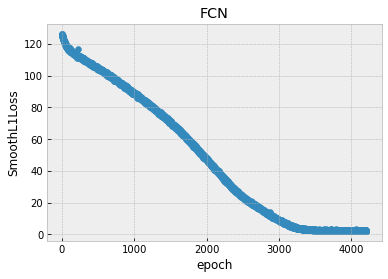

In [13]:
len(loss_item)
x = [i for i in range(4210)]
plt.scatter(x,loss_item)
plt.xlabel("epoch")
plt.ylabel("SmoothL1Loss")
plt.title("FCN")

In [14]:
net.eval()
test_loss = nn.MSELoss().cuda()
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
    MSE = test_loss(y,output).item()
print("CNN: on the test dataset MSE = {}".format(MSE))

CNN: on the test dataset MSE = 615.4189453125
